This file is to test my model on the TUH-EEG-seizure data

I call it as new, because I used a new way to save the model (on May 20, 2023)


In [42]:
RUN_PYTHON_SCRIPT = False
MODEL_NAME = "Lay2_dis_10step_latent_intervalbds_no_model_epoch3"
SAVED_MODEL = None

In [43]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT

In [44]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import time

if not RUN_PYTHON_SCRIPT:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [45]:
import importlib
import data_utils.eeg_load
importlib.reload(data_utils.eeg_load)

<module 'data_utils.eeg_load' from '/data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/data_utils/eeg_load.py'>

In [46]:
from models.model_utils import generate_position_encode, load_model_class
from data_utils.eeg_load import EEG_data, MyDataLoader, digitize_data, rec_data
from utils.misc import delta_time, load_pkl_folder2dict, save_pkl_dict2folder

In [47]:
# pkgs for pytorch (on Apr 3, 2023)
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    #torch.cuda.set_device(3)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda")
else:
    torch.set_default_tensor_type(torch.DoubleTensor)
    device = torch.device("cpu")

# Load data and model

In [49]:
model_utils = load_pkl_folder2dict(RES_ROOT/f"{MODEL_NAME}", including=["config*", "losses*"]);
module = load_model_class(RES_ROOT/MODEL_NAME);
model = module.myNet(model_utils.config);
model.load_state_dict(torch.load(RES_ROOT/MODEL_NAME/"model.pth", map_location=torch.device('cpu')));

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../results/Lay2_dis_10step_latent_intervalbds_no_model_epoch3/config.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../results/Lay2_dis_10step_latent_intervalbds_no_model_epoch3/losses.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../results/Lay2_dis_10step_latent_intervalbds_no_model_epoch3/losses_test.pkl
number of parameters: 1.59M


# Inference

In [50]:
from sklearn.metrics import confusion_matrix

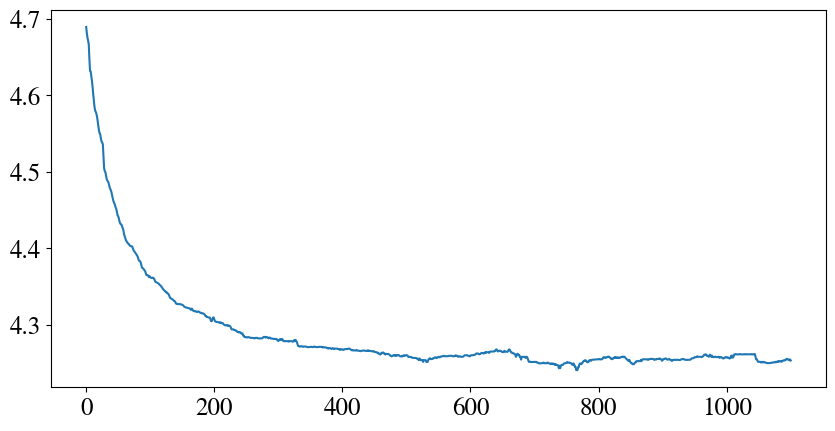

In [53]:
def moving_median(data, window_size):
    if window_size < 1 or not isinstance(window_size, int):
        raise ValueError("Window size must be a positive integer")

    if len(data) < window_size:
        raise ValueError("Window size must be smaller than or equal to the length of the data")

    result = []
    for i in range(len(data) - window_size + 1):
        result.append(np.median(data[i:i + window_size]))
    return result
plt.plot(moving_median(model_utils.losses_test[:], 100))
#plt.plot(moving_median(model_utils.losses[:], 100))
#plt.yscale("log")

In [54]:
config = model_utils.config
trained_model = model;
pos_enc = generate_position_encode(config.block_size, config.nfeature).unsqueeze(0);

In [55]:
def raw2input(X, pos_enc):
    X_input = X + pos_enc
    X_raw = X
    return X_input, X_raw

def _raw_pred_dis(X):
    X_inp, X_raw = raw2input(X, pos_enc)
    trained_model.eval()
    with torch.no_grad():
        Y_pred_prbs = trained_model(X_inp, X_raw)
    Y_pred_dis = Y_pred_prbs.argmax(axis=-1)
    Y_pred = rec_data(Y_pred_dis.cpu().numpy(), config.k)
    Y_pred = torch.tensor(Y_pred)
    return Y_pred

def _raw_pred_dis_prb(X):
    X_inp, X_raw = raw2input(X, pos_enc)
    trained_model.eval()
    with torch.no_grad():
        Y_pred_prbs = trained_model(X_inp, X_raw)
    return Y_pred_prbs

In [56]:
def pred_steps(X_init, raw_pred, num_step):
    """To make num_step prediction based on X_init 
        args:
            X_init: batchsize x blocksize x numseq, tensor
            raw_pred: A fn to make prediction for 1 step
            num_step: num of steps
    """
    X_ext = X = X_init 
    for k in range(num_step):
        Y_pred = raw_pred(X);
        X_ext = torch.cat([X_ext, Y_pred[:, -1:, :]], axis=1)
        X = X_ext[:, -config.block_size:]
    Y_pred_mul = X_ext[:, -num_step:];
    return Y_pred_mul

## predict 1 step

In [57]:
train_data = EEG_data("train_train_health", "AR", 
                      move_dict=dict(winsize=config.block_size+config.move_step,
                                     stepsize=config.block_size+config.move_step,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False), 
                      scale_fct=None
                     )
test_data = EEG_data("train_test_health", "AR", 
                      move_dict=dict(winsize=config.block_size+config.move_step, 
                                     stepsize=config.block_size+config.move_step, 
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False), 
                     scale_fct=None
                    )

train_data_loader = MyDataLoader(train_data, batch_size=1, shuffle=False)
test_data_loader = MyDataLoader(test_data, batch_size=4, shuffle=False)
print(len(train_data_loader), len(test_data_loader))

524657 11047


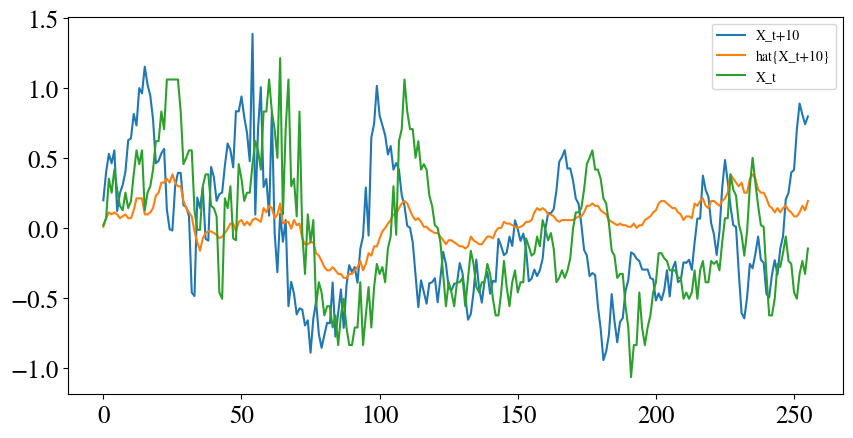

In [59]:
ix = 5
batch = test_data_loader(ix)
#batch = train_data_loader(ix)
X, Y_true = batch[:, :-config.move_step], batch[:, config.move_step:]
X_rec = torch.tensor(rec_data(digitize_data(X.numpy(), config.k), config.k))
Y_true_rec = torch.tensor(rec_data(digitize_data(Y_true.numpy(), config.k), config.k))

Y_pred = _raw_pred_dis(X_rec)
sub_idx = 2
seq_idx = 0
plt.plot(Y_true[sub_idx, :, seq_idx], label="X_t+10")
plt.plot(Y_pred[sub_idx, :, seq_idx], label="hat{X_t+10}")
plt.plot(X_rec[sub_idx, :, seq_idx], label="X_t")
plt.legend(fontsize=10)

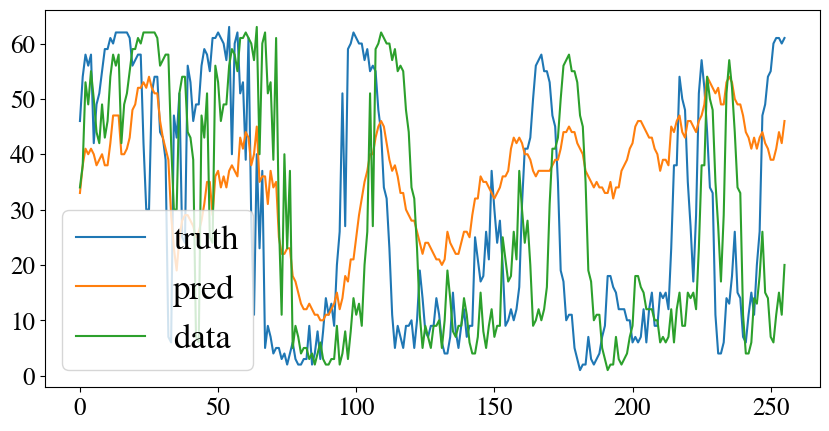

In [60]:
Y_pred_prb = _raw_pred_dis_prb(X_rec);
Y_pred_dis = Y_pred_prb.argmax(-1)
X_dis = digitize_data(X, config.k)

Y_true_dis = digitize_data(Y_true, config.k)

plt.plot(Y_true_dis[sub_idx, :, seq_idx], label="truth")
plt.plot(Y_pred_dis[sub_idx, :, seq_idx], label="pred")
plt.plot(X_dis[sub_idx, :, seq_idx], label="data")
plt.legend()

<AxesSubplot:>

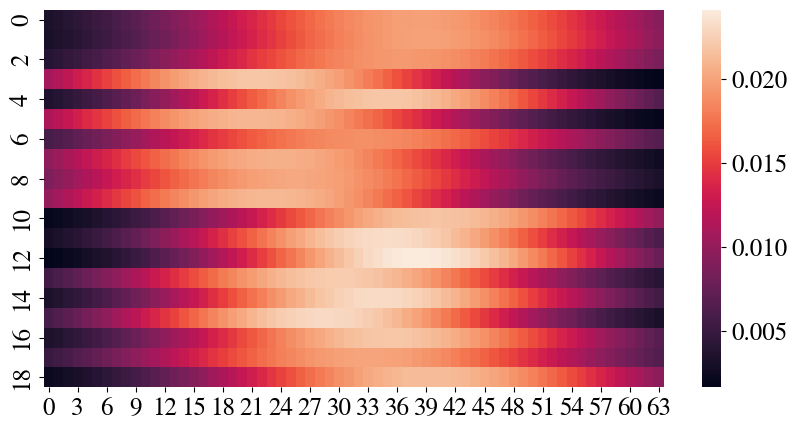

In [61]:
sns.heatmap(Y_pred_prb[sub_idx, 1])

### Hook variable

In [27]:
hook_out = None

def hook_fn(module, input, output):
    global hook_out 
    hook_out = output

hook = trained_model.softplus.register_forward_hook(hook_fn)

X_inp, X_raw = raw2input(X_rec, pos_enc)
trained_model.eval()
with torch.no_grad():
    Y_pred_prbs = trained_model(X_inp, X_raw)
hook.remove()

<AxesSubplot:>

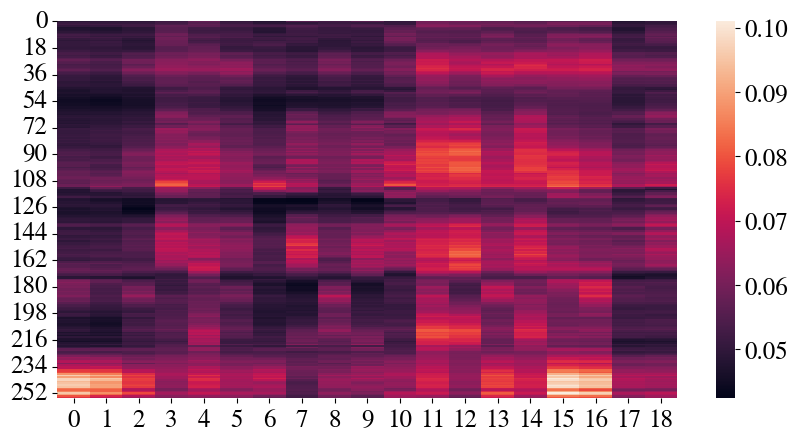

In [34]:
sns.heatmap(hook_out[1])

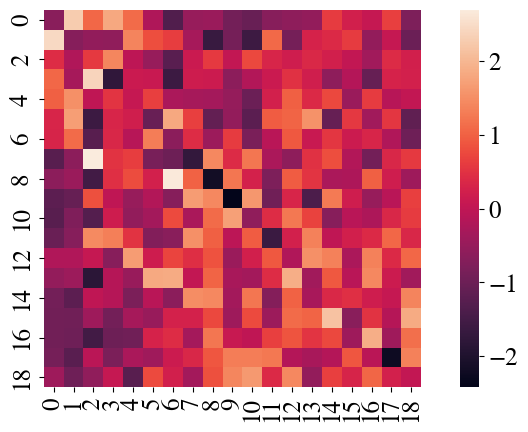

In [55]:
Amats = hook_out.reshape(1, 256, 19, 19);
sns.heatmap(Amats[0, 1], square=True)
AXs = torch.matmul(Amats, X_raw.unsqueeze(-1)).squeeze(-1)/9;
X_new = AXs + X_raw;

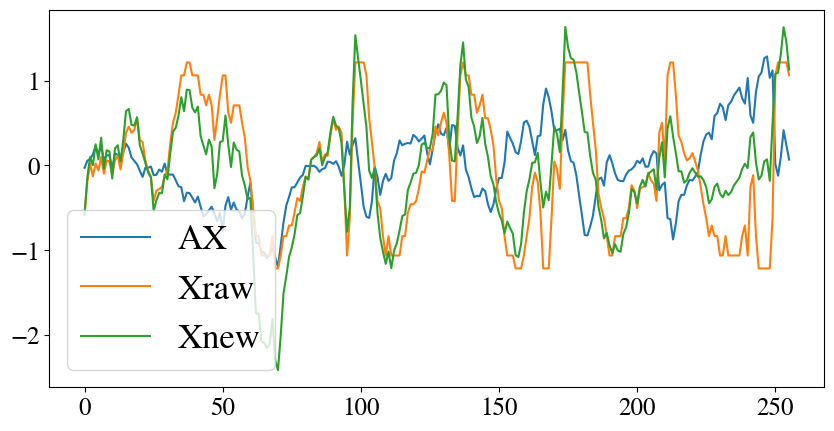

In [54]:
plt.plot(AXs[0, :, 0], label="AX")
plt.plot(X_raw[0, :, 0], label="Xraw")
plt.plot(X_new[0, :, 0], label="Xnew")
plt.legend()

## Predict multiple steps

In [35]:
start_t = 2000
full_seq = torch.tensor(test_data["sub1"]);
full_seq = full_seq[start_t:]
full_seq = full_seq.unsqueeze(0);
X_init = full_seq[:, :config.block_size];

num_step = 10
Y_pred_mul = pred_steps(X_init, _raw_pred_dis, num_step);

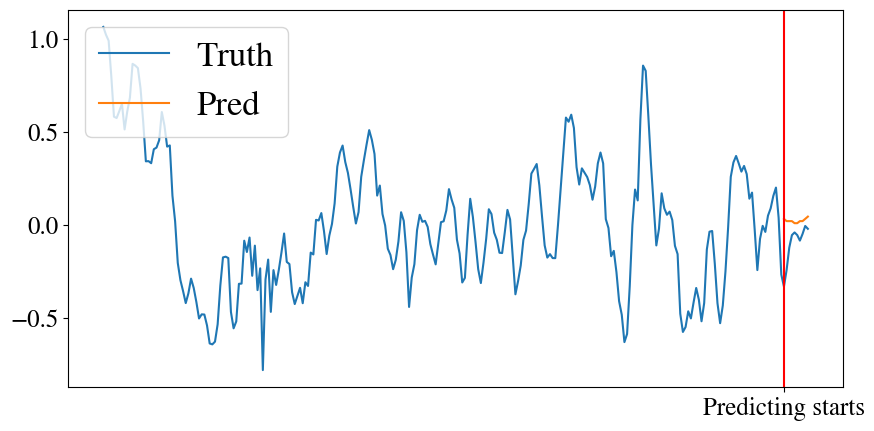

In [36]:

batch_idx = 0
seq_idx = 1
Y_pred_mul_sel = Y_pred_mul[batch_idx]
Y_true_mul_full_sel = full_seq[batch_idx, :(len(Y_pred_mul_sel)+config.block_size)]

plt.plot(Y_true_mul_full_sel[:, seq_idx], label="Truth")
plt.plot(np.arange(config.block_size, len(Y_true_mul_full_sel)), Y_pred_mul_sel[:, seq_idx], label="Pred")
plt.axvline(x=config.block_size, color="red")
plt.xticks([config.block_size], ["Predicting starts"])
plt.legend(loc="upper left")

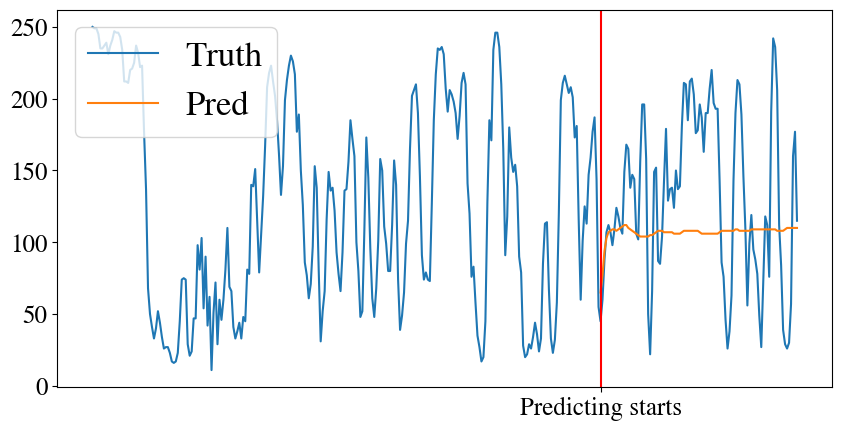

In [23]:
Y_pred_mul_sel_dis = digitize_data(Y_pred_mul_sel, config.k)
Y_true_mul_full_sel_dis = digitize_data(Y_true_mul_full_sel, config.k)

plt.plot(Y_true_mul_full_sel_dis[:, seq_idx], label="Truth")
plt.plot(np.arange(config.block_size, len(Y_true_mul_full_sel_dis)), Y_pred_mul_sel_dis[:, seq_idx], label="Pred")
plt.axvline(x=config.block_size, color="red")
plt.xticks([config.block_size], ["Predicting starts"])
plt.legend(loc="upper left")

<AxesSubplot:>

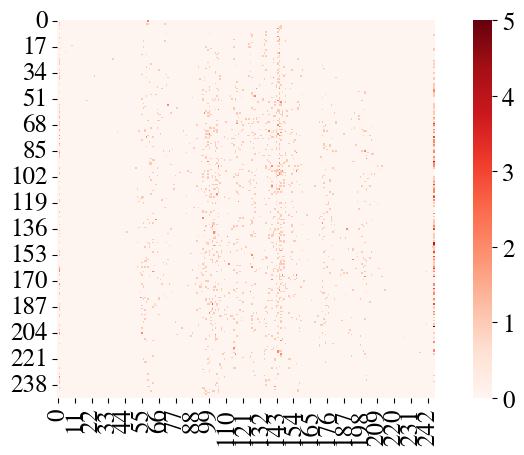

In [24]:
vec_true = Y_true_mul_full_sel_dis[config.block_size:].flatten();
vec_pred = Y_pred_mul_sel_dis.flatten();
conf_mat = confusion_matrix(vec_true, vec_pred);
sns.heatmap(conf_mat, square=True,  cmap="Reds")

## evaluate

In [25]:
from collections import defaultdict as ddict

In [28]:
num_step_uplimit = 256 
train_data = EEG_data("train_train_health", "AR", 
                      move_dict=dict(winsize=config.block_size+num_step_uplimit,
                                     stepsize=config.block_size+num_step_uplimit,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False), 
                      scale_fct=None
                     )
test_data = EEG_data("train_test_health", "AR", 
                      move_dict=dict(winsize=config.block_size+num_step_uplimit, 
                                     stepsize=config.block_size+num_step_uplimit, 
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False), 
                     scale_fct=None
                    )

train_data_loader = MyDataLoader(train_data, batch_size=4, shuffle=False)
test_data_loader = MyDataLoader(test_data, batch_size=4, shuffle=False)

In [29]:
for num_step in [1, 2, 4, 8, 16, 32, 64, 128]:
    save_path = MIDRES_ROOT/f"{MODEL_NAME}_{num_step}step_pred_labs"
    if save_path.exists():
        save_res = load_pkl_folder2dict(save_path)
    else:
        save_res = ddict(list)
    
    all_true_dis = []
    all_pred_dis = []
    sel_idxs = np.random.choice(len(test_data_loader), size=int(128/num_step), replace=False)
    #sel_idxs = np.arange(int(128/num_step))
    for ix in tqdm(sel_idxs, desc=f"{num_step} step"):
    
        batch = test_data_loader(ix) 
        X_init = batch[:, :config.block_size];
        Y_true_mul = batch[:, config.block_size:(config.block_size+num_step)]
        Y_pred_mul = pred_steps(X_init, _raw_pred_dis, num_step)
        
        Y_true_mul_dis = digitize_data(Y_true_mul.cpu().numpy(), config.k);
        Y_pred_mul_dis = digitize_data(Y_pred_mul.cpu().numpy(), config.k);
        all_true_dis.append(Y_true_mul_dis.flatten())
        all_pred_dis.append(Y_pred_mul_dis.flatten());
        
    all_true_dis = np.concatenate(all_true_dis)
    all_pred_dis = np.concatenate(all_pred_dis);
    
    save_res["all_trues_dis"].append(all_true_dis)
    save_res["all_preds_dis"].append(all_pred_dis)
    save_pkl_dict2folder(save_path, save_res, is_force=True, verbose=False)

128 step: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.64s/it]


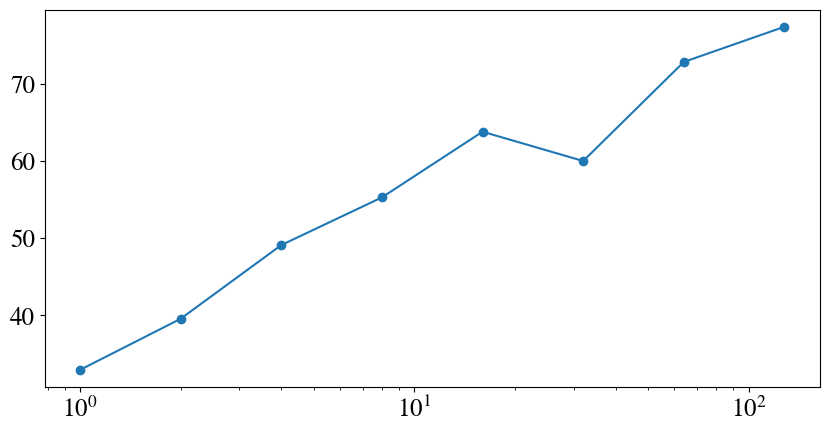

In [30]:
_key_fn = lambda f: int(f.stem.split("step")[1].split("_")[-1])
def _measure_fn(a, b):
    return np.mean(np.abs(a-b))

fils = list(MIDRES_ROOT.glob(f"{MODEL_NAME}_*"));
steps = np.array([_key_fn(f) for f in fils]);
fils = sorted(fils, key=_key_fn);

measures = []
for fil in fils:
    cur_res = load_pkl_folder2dict(fil, verbose=False)
    measures.append(np.mean([_measure_fn(a, b) for a, b in zip(cur_res.all_preds_dis, cur_res.all_trues_dis)]))
    
plt.plot(steps, measures, "-o")
plt.xscale("log")

<AxesSubplot:>

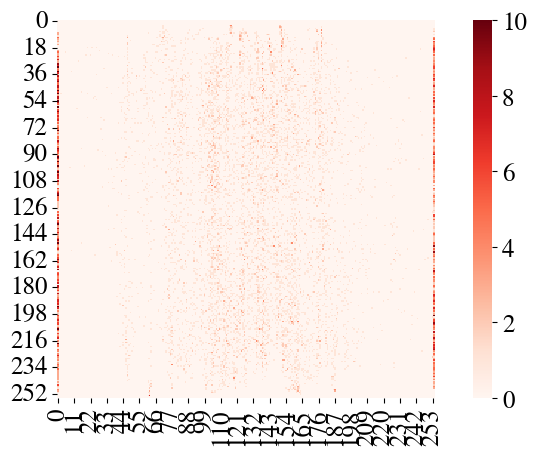

In [31]:
conf_mat = confusion_matrix(all_true_dis, all_pred_dis);
sns.heatmap(conf_mat, square=True, cmap="Reds", vmax=10)

## Code bak

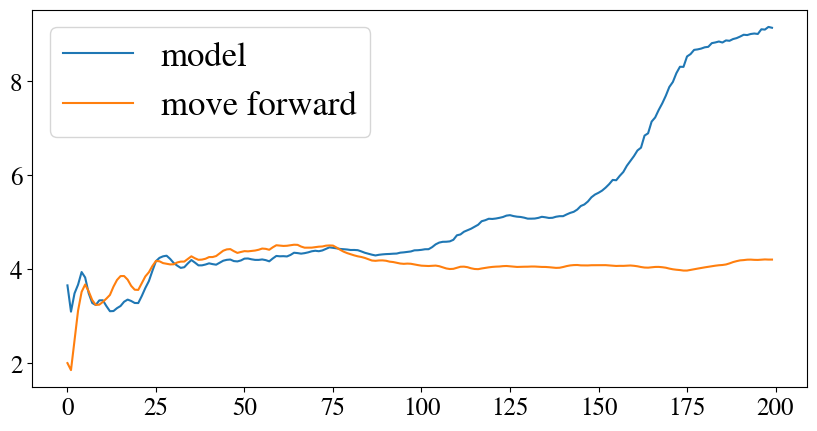

In [ ]:
len_seq = 100
loss_vs = []
for len_seq in range(1, pred_step+1):
    obs_data = full_seq[:, config.block_size:(config.block_size+len_seq)]
    move_f = torch.ones_like(obs_data) * full_seq[:, (config.block_size-1):config.block_size, :]
    pred_from_model = X_ext[:, config.block_size:(config.block_size+len_seq), :];
    loss_vs.append(
        (loss_fn(obs_data, pred_from_model).item(), 
        loss_fn(obs_data, move_f).item())
    )
loss_vs = np.array(loss_vs);
plt.plot(loss_vs[:, 0], label="model")
plt.plot(loss_vs[:, 1], label="move forward")
plt.legend()

# try

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.69it/s]


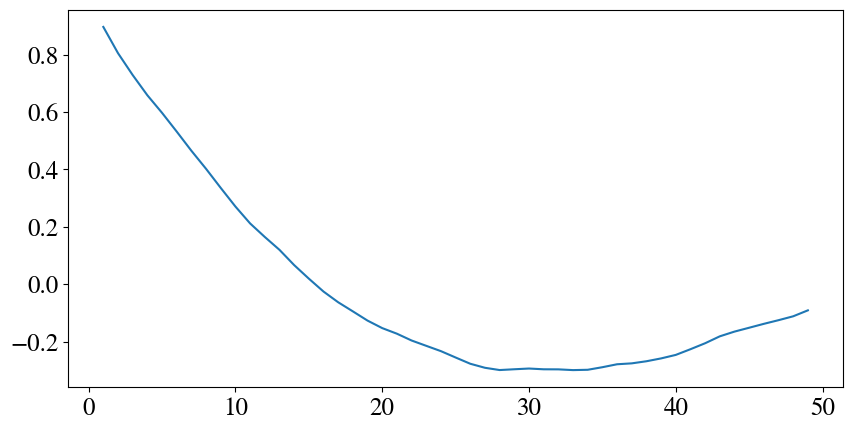

In [151]:
# Autocorrelation Function, 
# k is a good lag
import scipy
ix = 1
stepk = 2
stepks = list(range(1, 50))
prs = []
for stepk in tqdm(stepks):
    batch = test_data_loader(ix)
    X1 = batch[:, :-stepk].numpy()
    X2 = batch[:, stepk:].numpy();
    
    def pears_fn(X1, X2):
        len1, _, len3 = X1.shape
        r_mat = np.zeros((len1, len3))
        for ix in range(len1):
            for iy in range(len3):
                r_mat[ix, iy] = scipy.stats.pearsonr(X1[ix, :, iy], X2[ix, :, iy])[0]
        return r_mat
    pr_mean = pears_fn(X1, X2).mean()
    prs.append(pr_mean)
plt.plot(stepks, prs)